In [1]:
from pyspark import sql
from lib import common_functions
from lib import configuration

In [2]:
spark = common_functions.get_spark_session('dp203')
spark.active()

Variables

In [3]:
twenty_n_path = configuration.dp203_input_path+'/2019.csv'
twenty_t_path = configuration.dp203_input_path+'/2020.csv'
twenty_to_path = configuration.dp203_input_path+'/2021.csv'

twenty_n_path

'/home/jovyan/code/files/input/dp203//2019.csv'

Dataframes

In [4]:
df_twenty_n = spark.read.format("csv").options(header='true', inferSchema='true', delimiter=',').load(twenty_n_path)
df_twenty_n.show(n=100)

+----------------+--------------------+----------+------------------+--------------------+--------------------+--------+---------+---------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|      CustomerName|        EmailAddress|                Item|Quantity|UnitPrice|TaxAmount|
+----------------+--------------------+----------+------------------+--------------------+--------------------+--------+---------+---------+
|         SO43701|                   1|2019-07-01|       Christy Zhu|christy12@adventu...|Mountain-100 Silv...|       1|  3399.99| 271.9992|
|         SO43704|                   1|2019-07-01|        Julio Ruiz|julio1@adventure-...|Mountain-100 Blac...|       1|  3374.99| 269.9992|
|         SO43705|                   1|2019-07-01|         Curtis Lu|curtis9@adventure...|Mountain-100 Silv...|       1|  3399.99| 271.9992|
|         SO43700|                   1|2019-07-01|      Ruben Prasad|ruben10@adventure...|  Road-650 Black, 62|       1| 699.0982|  55.9279|
|         SO4

In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
    ])

df = spark.read.option("header", True).load(f'{configuration.dp203_input_path}/*.csv', format='csv', schema=orderSchema)
df.show()
df.count()

+----------------+--------------------+----------+-------------------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|       CustomerName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+-------------------+--------------------+--------------------+--------+---------+--------+
|         SO49171|                   1|2021-01-01|      Mariah Foster|mariah21@adventur...|  Road-250 Black, 48|       1|2181.5625| 174.525|
|         SO49172|                   1|2021-01-01|       Brian Howard|brian23@adventure...|    Road-250 Red, 44|       1|  2443.35| 195.468|
|         SO49173|                   1|2021-01-01|      Linda Alvarez|linda19@adventure...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49174|                   1|2021-01-01|     Gina Hernandez|gina4@adventure-w...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO4

32718

In [6]:
df.printSchema()

root
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: integer (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- CustomerName: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- Tax: float (nullable = true)



Filters

In [ ]:
customers = df['CustomerName', 'Email']
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())

32718
12427


DataFrame[CustomerName: string, Email: string]

In [8]:
customers = df.select("CustomerName", "Email").where(df['Item']=='Road-250 Red, 52')
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())

133
133


DataFrame[CustomerName: string, Email: string]

Aggregate

In [9]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum()
productSales.show()

+--------------------+-------------+
|                Item|sum(Quantity)|
+--------------------+-------------+
|Mountain-200 Blac...|          388|
|Touring-1000 Yell...|           74|
|Touring-1000 Blue...|           67|
|Short-Sleeve Clas...|          216|
|Women's Mountain ...|          146|
|Long-Sleeve Logo ...|          234|
|Mountain-400-W Si...|           59|
|     Racing Socks, M|          165|
|Mountain-200 Silv...|          359|
|  Road-750 Black, 58|          170|
|Half-Finger Glove...|          209|
|Road-350-W Yellow...|           81|
|Mountain-400-W Si...|           68|
|Mountain Bottle Cage|         1000|
|Touring-1000 Blue...|           75|
|Mountain-500 Silv...|           22|
|    HL Mountain Tire|          702|
|Mountain-400-W Si...|           61|
|Bike Wash - Disso...|          473|
|Road-550-W Yellow...|          156|
+--------------------+-------------+
only showing top 20 rows



In [10]:
yearlySales = df.select(year("OrderDate").alias("Year")).groupBy("Year").count().orderBy("Year")
yearlySales.show()

+----+-----+
|Year|count|
+----+-----+
|2019| 1201|
|2020| 2733|
|2021|28784|
+----+-----+



Query

In [11]:
df.createOrReplaceTempView("salesorders")

spark_df = spark.sql("SELECT * FROM salesorders")
spark_df.show()

+----------------+--------------------+----------+-------------------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|       CustomerName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+-------------------+--------------------+--------------------+--------+---------+--------+
|         SO49171|                   1|2021-01-01|      Mariah Foster|mariah21@adventur...|  Road-250 Black, 48|       1|2181.5625| 174.525|
|         SO49172|                   1|2021-01-01|       Brian Howard|brian23@adventure...|    Road-250 Red, 44|       1|  2443.35| 195.468|
|         SO49173|                   1|2021-01-01|      Linda Alvarez|linda19@adventure...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49174|                   1|2021-01-01|     Gina Hernandez|gina4@adventure-w...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO4

In [ ]:
# %%sql
# SELECT YEAR(OrderDate) AS OrderYear,
#     SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
# FROM salesorders
# GROUP BY YEAR(OrderDate)
# ORDER BY OrderYear;

UsageError: Cell magic `%%sql` not found.


matplotlib

In [14]:
sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
                SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
            FROM salesorders \
            GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
            ORDER BY OrderYear"
df_spark = spark.sql(sqlQuery)
df_spark.show()

+---------+--------------------+
|OrderYear|        GrossRevenue|
+---------+--------------------+
|     2019|   4172169.969970703|
|     2020|   6882259.268127441|
|     2021|1.1547835291696548E7|
+---------+--------------------+



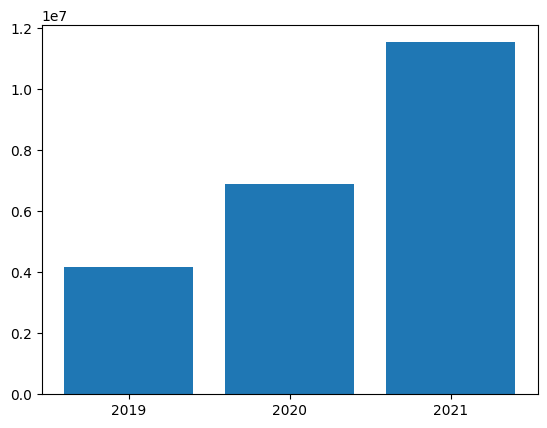

In [15]:
from matplotlib import pyplot as plt

# matplotlib requires a Pandas dataframe, not a Spark one
df_sales = df_spark.toPandas()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'])

# Display the plot
plt.show()

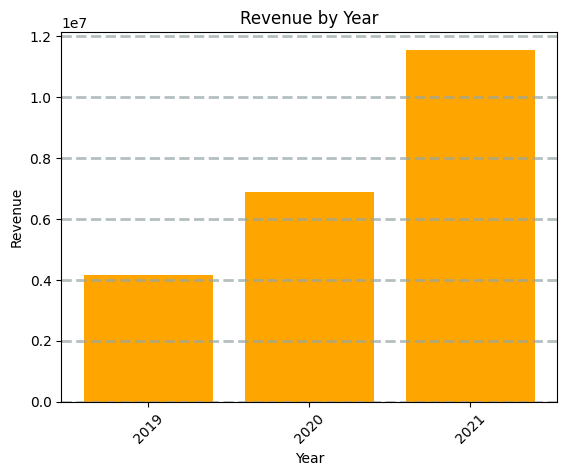

In [16]:
# Clear the plot area
plt.clf()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

<Figure size 640x480 with 0 Axes>

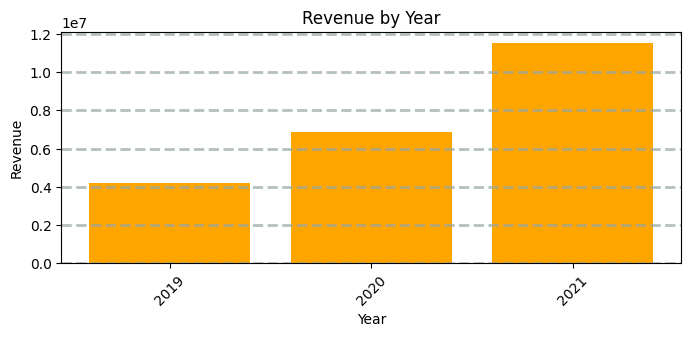

In [17]:
# Clear the plot area
plt.clf()

# Create a Figure
fig = plt.figure(figsize=(8,3))

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

<Figure size 640x480 with 0 Axes>

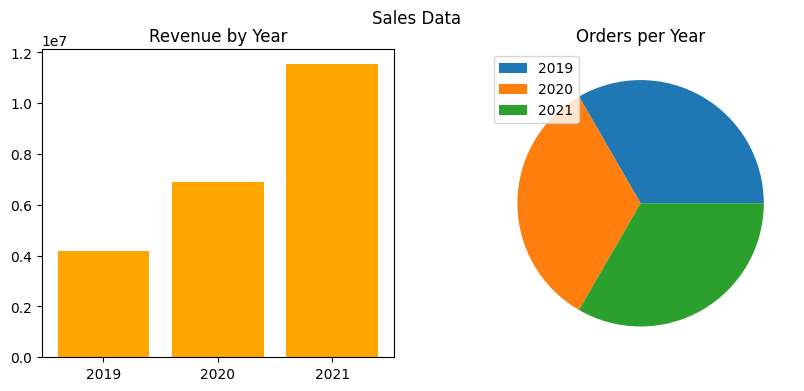

In [18]:
# Clear the plot area
plt.clf()

# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Create a bar plot of revenue by year on the first axis
ax[0].bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
ax[0].set_title('Revenue by Year')

# Create a pie chart of yearly order counts on the second axis
yearly_counts = df_sales['OrderYear'].value_counts()
ax[1].pie(yearly_counts)
ax[1].set_title('Orders per Year')
ax[1].legend(yearly_counts.keys().tolist())

# Add a title to the Figure
fig.suptitle('Sales Data')

# Show the figure
plt.show()

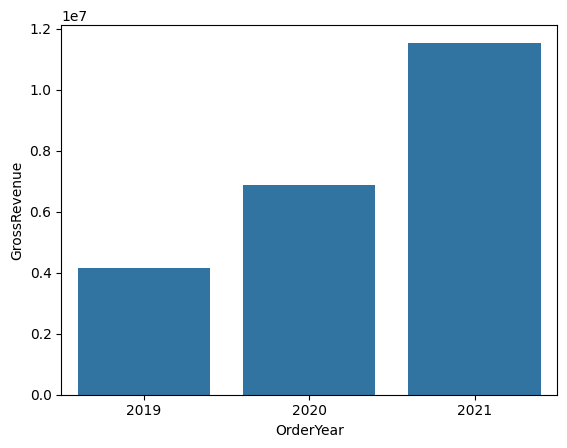

In [20]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

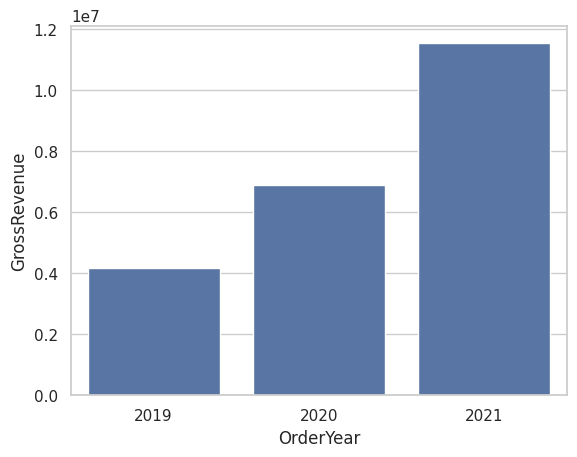

In [21]:
# Clear the plot area
plt.clf()

# Set the visual theme for seaborn
sns.set_theme(style="whitegrid")

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

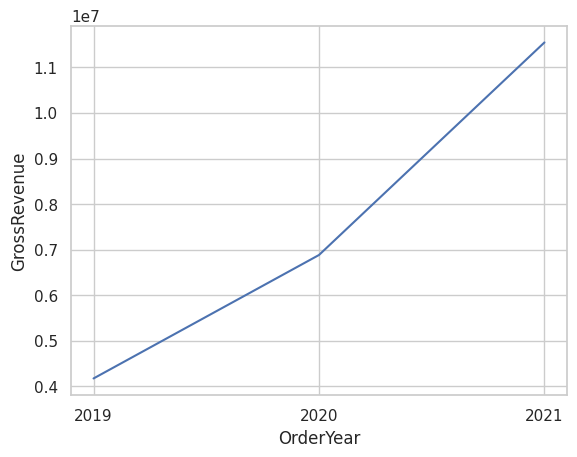

In [22]:
# Clear the plot area
plt.clf()

# Create a bar chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()